In [33]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import jieba

input_folder = "C:\\Users\\fento\\Downloads\\gameID_reviews_cleaned\\all_reviews.xlsx"
stop_word_path = 'C:\\Users\\fento\\Downloads\\gameID_reviews_cleaned\\stop_words.txt'
data = pd.read_excel(input_folder)
data = data.sort_values('play_time', ascending=False)
data.reset_index(inplace=True)
sub_contents = data['reviews2']
print(sub_contents)
text = str()
text = ''.join(sub_contents)
print('文本長度', len(text))

0                                              祝你們老婆都被NTR
1                                                    外掛成群
2       遊戲再好玩，不尊重玩家也是沒什麼好說的！\n-------\n更新徽章評論\n更新2019夏...
3                       使用莫須有的罪名亂封鎖人，沒水準，跟流氓有什麼不同，強烈不建議購買
4                                            \n玩這遊戲的絕對是傻逼
                              ...                        
7187                    玩不了 名也改不了\n只要有 H K 和 香 港 連著的名都不可用
7188                                                 Sb垃圾
7189                                       \n無法連線 連遊戲都進不去
7190                                       遊戲根本就開不起來，怎麼玩?
7191                                          動作超生硬，山寨味超重
Name: reviews2, Length: 7192, dtype: object
文本長度 519101


In [34]:
import requests
from bs4 import BeautifulSoup
import re, os
import pandas as pd
import jieba

def split_text(chinese_text, cut_all=False):
    text_generater = jieba.cut(chinese_text, cut_all=cut_all)
    result = ' '.join(text_generater)
    return result

def drop_stop_words(st_path, chinese_text):
    with open(st_path, 'r', encoding='utf-8') as f:
        st = f.read()
        st_list = st.splitlines()
    word_list = chinese_text.split()
    
    for stop_word in st_list:
        word_list = [word for word in word_list if word != stop_word]
    return word_list

def caculate_words(word_list, threshold=50):
    count_dict = {}
    for word in word_list:
        count_dict[word] = count_dict[word] + 1 if word in count_dict else 1

    count_dict = {k: v for k, v in count_dict.items() if v >= threshold}
    keyword_list = list(count_dict.items())
    return keyword_list

stop_word_path = 'C:\\Users\\fento\\Downloads\\gameID_reviews_cleaned\\stop_words_2.txt'

text = split_text(text, cut_all=False)
word_list = drop_stop_words(stop_word_path, text)
keyword_list = caculate_words(word_list, threshold=50)
print(keyword_list)

[('們', 137), ('外掛', 1475), ('遊戲', 2951), ('好玩', 563), ('，', 11757), ('玩家', 1062), ('！', 747), ('更新', 362), ('評論', 77), ('使用', 232), ('亂', 78), ('封鎖', 137), ('不同', 93), ('購買', 77), ('這遊戲', 428), ('絕對', 59), ('傻', 93), ('逼', 176), ('它', 90), ('西部', 143), ('於', 248), ('這款', 214), ('所有', 104), ('讚', 218), ('該', 76), ('故事', 267), ('模式', 479), ('。', 2845), ('三', 56), ('主角', 53), ('出', 1126), ('劇情', 397), ('個', 396), ('各種', 156), ('想', 446), ('辦法', 66), ('錢', 376), ('買', 561), ('東西', 160), ('從', 190), ('沒', 977), ('戰局', 112), ('死', 335), ('製', 131), ('中', 210), ('一般', 55), ('整個', 73), ('內', 69), ('時', 138), ('只會', 104), ('看到', 159), ('別', 81), ('地', 78), ('比', 235), ('每天', 76), ('封', 189), ('？', 650), ('垃圾', 4816), ('線上', 135), ('很爛', 61), ('線', 109), ('公司', 206), ('被鎖', 72), ('申訴', 77), ('著', 111), ('R', 267), ('明明', 57), ('結果', 168), ('真是', 57), ('一次', 150), ('狗', 119), ('部分', 85), ('作', 109), ('圖', 51), ('這些', 93), ('手', 60), ('”', 53), ('“', 55), ('直接', 283), ('這種', 105), ('以及', 104), ('完

In [35]:
from pyecharts.charts import Line, Timeline, Bar, Scatter, WordCloud
cloud = (WordCloud()
         .add('', keyword_list, word_size_range=[30, 130])
         )
cloud.render_notebook()

In [36]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import re
import jieba
import gensim
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] 
data = pd.read_excel(r'C:\\Users\\fento\\Downloads\\gameID_reviews_cleaned\\all_reviews.xlsx')

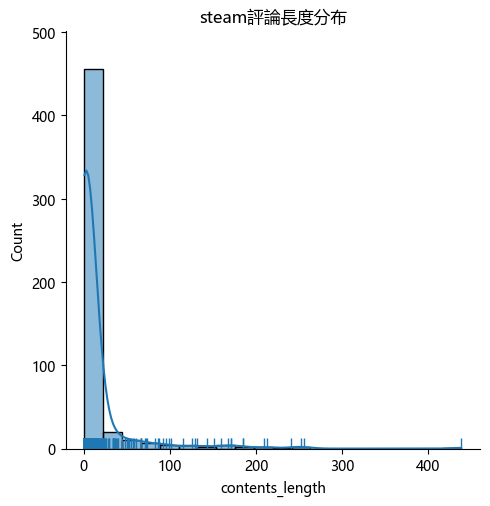

評論長度的9/10分位數： 150.0


In [37]:
data['contents_length'] = data['reviews2'].apply(lambda x: len(str(x)))
len_se = data.groupby('contents_length')['contents_length'].count()
sns.displot(len_se, bins=20, kde=True, rug=True)
plt.title('steam評論長度分布')
plt.show()
print('評論長度的9/10分位數：', data['contents_length'].quantile(0.9))

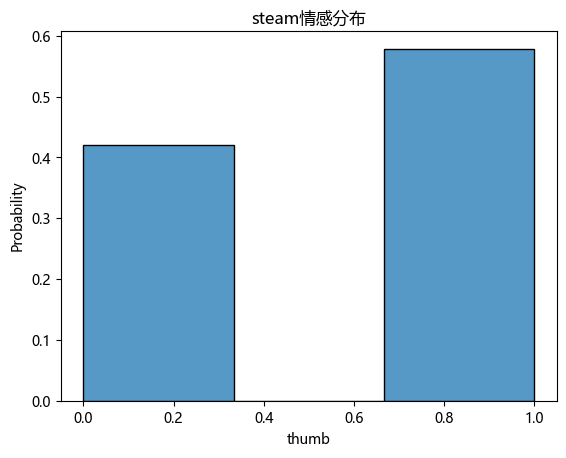

正面評價: 3029，占總數的42.12%    負面評價: 4163, 占總數的57.88%


In [38]:
positive = len(data['thumb'][data['thumb'] == 0])
total = len(data['thumb'])
negative = total - positive
sns.histplot(data['thumb'], bins=3, kde=False, stat="probability")
plt.title('steam情感分布')
plt.show()
print('正面評價: %d，占總數的%.2f%%    負面評價: %d, 占總數的%.2f%%' %
      (positive, (positive/total*100), negative, (negative/total*100)))

In [39]:
nan_index = data[data['reviews2'].isnull()].index.tolist()
data.drop(nan_index, inplace=True)
X = data['reviews2']
Y = data['thumb']

In [40]:
def split_text(chinese_text, cut_all=False):
    text_generater = jieba.cut(chinese_text, cut_all=cut_all)
    result = ' '.join(text_generater)
    return result

def drop_stop_words(st_path, chinese_text):
    with open(st_path, 'r',encoding='utf-8') as f:
        st = f.read()
        st_list = st.splitlines()
    word_list = chinese_text.split()

    for stop_word in st_list:
        word_list = [word for word in word_list if word != stop_word]
    return word_list

In [41]:
# 中文分词
#X.dropna(inplace=True)
X = X.apply(lambda x: split_text(x))
# 3.去除中文停用词
X = X.apply(lambda x: drop_stop_words(r'C:\\Users\\fento\\Downloads\\gameID_reviews_cleaned\\stop_words_2.txt', x))

In [42]:
def train_Word2Vec_model(text, save_path):
    model = gensim.models.Word2Vec(text, vector_size=100, min_count=1, window=5)
    model.save(save_path)
    return model

def word_to_dict(X, word_vec_model):
    total_set = set()
    word_to_vec = dict()
    word_to_index = dict()
    for x in X:
        total_set = set.union(total_set, set(x))
    
    index = 1
    for i in total_set:
        word_to_vec[i] = word_vec_model.wv[i]
        word_to_index[i] = index
        index += 1
    return word_to_vec, word_to_index

In [43]:
import gensim
word_vec_model = train_Word2Vec_model(X, r'C:\Users\fento\Downloads\model\word2vec_2.model')
word_to_vec, word_to_index = word_to_dict(X, word_vec_model)

In [44]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(Y), test_size=0.2, random_state=2)
print(X_train[9], '(0表示正向，1表示負向)：', y_train[9])

['西部', '打獵', '模擬器', '一堆', '能', '搜括', '東西', '倉鼠黨', '愛', ':', '3'] (0表示正向，1表示負向)： 0


In [45]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
def text_to_index(X, word_to_index, max_len=100):
    """
    :param X: 文字评论集
    :param word_to_index: dict, 词语到数字索引的映射
    :param max_len: int, 单个评论最大长度
    :return: 数字索引形式的评论集
    """
    m = X.shape[0]
    # 将索引初始化为0，后面会看到，0索引表示全为0的词向量
    X_indices = np.zeros((m, max_len))

    # 历遍评论
    for i in range(m):
        # 历遍词语，对超过最大长度的部分进行截断
        j = 0
        for word in X[i][:max_len]:
            if word in word_to_index:
                X_indices[i, j] = word_to_index[word]
                j += 1
    return X_indices

# 构建Embedding层
def pretrained_embedding_layer(word_to_vec, word_to_index):
    # 词汇量
    vocab_len = len(word_to_index) + 1                        # 这里加1，表示0向量占第一个位置
    # 词向量长度
    emb_dim = word_to_vec['遊戲'].shape[0] 

    # 初始化嵌入矩阵
    emb_matrix = np.zeros((vocab_len, emb_dim))
    # 用词向量填充嵌入矩阵，每行为一个词向量，嵌入矩阵的行索引对应word_to_index中的数字索引
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec[word]

    # 将嵌入矩阵传入Embedding层，作为权重矩阵
    weight = torch.from_numpy(emb_matrix)
    embedding = nn.Embedding.from_pretrained(weight)
    # 训练过程中不对weight进行微调
    embedding.weight.requires_grad = True

    return embedding

# 构建LSTM模型框架
class EmotionModel(nn.Module):
    def __init__(self, word_to_vec, word_to_index, max_len, hidden_dim):
        super(EmotionModel, self).__init__()
        # 词向量长度
        self.embedding_dim = word_to_vec['遊戲'].shape[0]
        # LSTM隐藏状态A的维度
        self.hidden_dim = hidden_dim
        # 句子最大长度
        self.max_len = max_len

        # 层次结构
        self.embedding = pretrained_embedding_layer(word_to_vec, word_to_index)
        self.lstm1 = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.hidden_dim, batch_first=True)
        self.dropout1 = nn.Dropout(0.5)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.dropout2 = nn.Dropout(0.5)
        self.linear = nn.Linear(self.hidden_dim*self.max_len, 1) 
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        # Embedding层要求输入LongTensor，进行转换
        embeds = self.embedding((inputs.long()))
        # LSTM层要求输入FloatTensor，进行转换
        # LSTM的输入维度(batch, seq_len, vec_len)，lstm_out的输出维度(batch, seq_len, n_a)
        lstm_out1, hidden = self.lstm1(embeds.view(-1, self.max_len, self.embedding_dim).float())
        drop_out1 = self.dropout1(lstm_out1)
        lstm_out2, hidden = self.lstm2(drop_out1.view(-1, self.max_len, self.hidden_dim).float())
        drop_out2 = self.dropout2(lstm_out2)
        fc_out1 = self.linear(drop_out2.contiguous().view(-1, self.max_len*self.hidden_dim))
        fc_out2 = self.sigmoid(fc_out1)
        return fc_out2
    
# 创建数据接口
def data_loader(X_train, y_train, batch_size=None):
    train_db = TensorDataset(torch.from_numpy(X_train).float(), torch.squeeze(torch.from_numpy(y_train)))
    train_loader = DataLoader(train_db, batch_size=batch_size, shuffle=True)
    return train_loader

# 训练模型并测试
def train_model(X_train, y_train, X_test, y_test, word_to_vec, word_to_index, params_save_path,
                max_len=100, batch_size=100, lr=0.002, epochs=400, hidden_dim=50):
    # 将X_train转换为数字索引形式
    X_train_indice = text_to_index(X_train, word_to_index, max_len=max_len)
    # 载入数据
    train_loader = data_loader(X_train_indice, y_train, batch_size=batch_size)
    # 创建网络结构
    model = EmotionModel(word_to_vec, word_to_index, max_len, hidden_dim)
    # 将模型移动至GPU
    device = torch.device("cpu")
    model = model.to(device)
    # 指定成本函数
    cost_func = nn.BCELoss()
    # 指定优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    # 批次数量
    m = len(X_train)
    num_batches = m / batch_size
   # 保存每步cost的列表
    costs = []

    for epoch in range(epochs):
        epoch_cost = 0
        for step, (batch_x, batch_y) in enumerate(train_loader):
            # 将变量移动至GPU
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            # 训练
            output = model.forward(batch_x)
            cost = cost_func(output.squeeze(), batch_y.float())
            epoch_cost += cost.item()
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

        epoch_cost /= num_batches
        costs.append(float(epoch_cost))
        print('Cost after epoch %i : %f' % (epoch, float(epoch_cost)))

    # 保存学习后的参数
    torch.save(model.state_dict(), params_save_path)
    print('參數已保存至本地pkl文件。')
    
    # 绘制学习曲线
    plt.plot(costs)
    plt.xlabel('iterations')
    plt.ylabel('cost')
    plt.show()
    
    # 将模型移动至cpu
    model = model.cpu()
    # 转换模型为测试模式，测试模式下不使用dropout层
    model = model.eval()
    # 训练集准确率
    output_train = model(torch.from_numpy(X_train_indice).float())
    pred_y_train = np.squeeze(np.round(output_train.data.numpy()).astype(int))
    print('Train Accuracy: %.2f%%' % float(np.sum(y_train == pred_y_train) / m * 100))
    
    # 测试集准确率
    X_test_indice = text_to_index(X_test, word_to_index, max_len=max_len)
    output_test = model(torch.from_numpy(X_test_indice).float())
    pred_y_test = np.squeeze(np.round(output_test.data.numpy()).astype(int))
    print('Test Accuracy: %.2f%%' % float(np.sum(y_test == pred_y_test) / len(X_test_indice) * 100))
    return pred_y_test

Cost after epoch 0 : 0.585621
Cost after epoch 1 : 0.227762
Cost after epoch 2 : 0.065347
Cost after epoch 3 : 0.039712
Cost after epoch 4 : 0.035570
Cost after epoch 5 : 0.029205
Cost after epoch 6 : 0.029122
Cost after epoch 7 : 0.024554
Cost after epoch 8 : 0.023674
Cost after epoch 9 : 0.027229
Cost after epoch 10 : 0.030026
Cost after epoch 11 : 0.027587
Cost after epoch 12 : 0.025972
Cost after epoch 13 : 0.024625
Cost after epoch 14 : 0.023053
Cost after epoch 15 : 0.023202
Cost after epoch 16 : 0.022398
Cost after epoch 17 : 0.021371
Cost after epoch 18 : 0.021249
Cost after epoch 19 : 0.019058
Cost after epoch 20 : 0.025705
Cost after epoch 21 : 0.023963
Cost after epoch 22 : 0.026849
Cost after epoch 23 : 0.025222
Cost after epoch 24 : 0.019169
Cost after epoch 25 : 0.017838
Cost after epoch 26 : 0.017085
Cost after epoch 27 : 0.018741
Cost after epoch 28 : 0.017485
Cost after epoch 29 : 0.016580
Cost after epoch 30 : 0.017755
Cost after epoch 31 : 0.020375
Cost after epoch 3

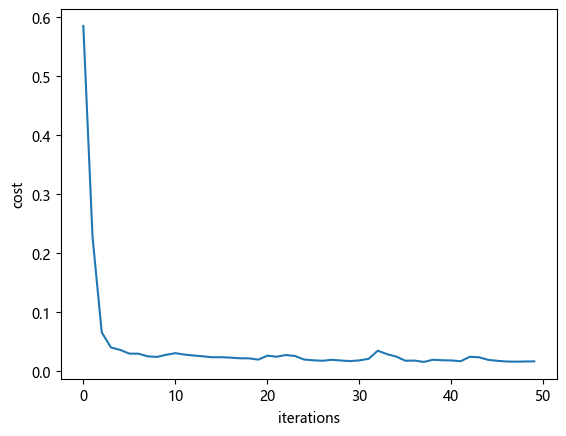

Train Accuracy: 99.44%
Test Accuracy: 84.43%


In [46]:
# 訓練模型
max_len = 70
batch_size = 80
hidden_dim = 50
params_save_path = r'C:\Users\fento\Downloads\model\emo_parms2.pkl'
pred_y_test = train_model(X_train, y_train, X_test, y_test, word_to_vec, word_to_index, params_save_path, 
                    max_len=max_len, batch_size=batch_size, hidden_dim=hidden_dim, lr=0.003, epochs=50)

In [47]:
# 混淆矩陣
def confuse_matrix(y, pred_y):
    fp = np.sum((pred_y==1)&(y==0))
    fn = np.sum((pred_y==0)&(y==1))
    tp = np.sum((pred_y==1)&(y==1))
    tn = np.sum((pred_y==0)&(y==0))
    confuse_matrix = np.array([[tp, fp], [fn, tn]])
    precision = tp / (fp+tp)
    recall = tp / (tp + fn)
    F1 = 2 * (precision*recall) / (precision+recall)
    print(confuse_matrix)
    print('Precision = %.2f,   Recall = %.2f    F1 = %.2f' % (precision, recall, F1))
confuse_matrix(y_test, pred_y_test)

[[708 102]
 [122 507]]
Precision = 0.87,   Recall = 0.85    F1 = 0.86


In [48]:
params_save_path = r'C:\Users\fento\Downloads\model\emo_parms2.pkl'
model = EmotionModel(word_to_vec, word_to_index, max_len, hidden_dim)
model.load_state_dict(torch.load(params_save_path))
model.eval()
# 待预测的评论
r1 = '說實話這是一款非常不錯的遊戲！畫質細膩，最重要的是可以切換橫屏豎屏！驚喜啊！現在想玩到高質量的豎屏暗黑遊戲太難啦！18元超值！'
r2 = '先不說肝不肝，這個遊戲的行走機制玩的真想讓人砸手機，跑步和行走就是在走格子，見怪停頓然後你走一步怪走一步，受不了。'
r3 = '這遊戲玩不懂啊，感覺引導很奇怪，然後裡面的機制也很奇怪，玩得一臉懵逼，啥跟啥都不知道...'
r4 = '遊戲是好遊戲，代理太差了，毫無徵兆說要開始測試，又隨便找個理由跳票，既然沒準備測試就不要放出消息啊，用這樣的方法刷一波存在感有意思嗎？'
r5 = '今天剛玩，感覺很有趣，製作很良心。很多細節。感覺應該挺耐玩。劇情寫得很有意思。很多可以探索的。感覺還蠻值得一玩的。'
r6 = '這些遊戲啊，進都不好進'
list1 = [r1, r2, r3, r4, r5, r6]
list2 = [drop_stop_words('C:\\Users\\fento\\Downloads\\gameID_reviews_cleaned\\stop_words_2.txt', split_text(item, cut_all=False)) for item in list1]

test_review_indice = text_to_index(np.array(list2,dtype=object), word_to_index, max_len=max_len)
output = model(torch.from_numpy(test_review_indice).float())
pred = np.squeeze(np.round(output.data.numpy()).astype(int))
for i, j, k in zip(list1, output, pred):
    print('----\n評論：', i)
    print('預測評分：', ('大於0.5' if float(j) <= 0.5 else '小於0.5'))
    print('預測情感：', ('正向' if k == 0 else '負向'))

----
評論： 說實話這是一款非常不錯的遊戲！畫質細膩，最重要的是可以切換橫屏豎屏！驚喜啊！現在想玩到高質量的豎屏暗黑遊戲太難啦！18元超值！
預測評分： 大於0.5
預測情感： 正向
----
評論： 先不說肝不肝，這個遊戲的行走機制玩的真想讓人砸手機，跑步和行走就是在走格子，見怪停頓然後你走一步怪走一步，受不了。
預測評分： 小於0.5
預測情感： 負向
----
評論： 這遊戲玩不懂啊，感覺引導很奇怪，然後裡面的機制也很奇怪，玩得一臉懵逼，啥跟啥都不知道...
預測評分： 大於0.5
預測情感： 正向
----
評論： 遊戲是好遊戲，代理太差了，毫無徵兆說要開始測試，又隨便找個理由跳票，既然沒準備測試就不要放出消息啊，用這樣的方法刷一波存在感有意思嗎？
預測評分： 小於0.5
預測情感： 負向
----
評論： 今天剛玩，感覺很有趣，製作很良心。很多細節。感覺應該挺耐玩。劇情寫得很有意思。很多可以探索的。感覺還蠻值得一玩的。
預測評分： 大於0.5
預測情感： 正向
----
評論： 這些遊戲啊，進都不好進
預測評分： 小於0.5
預測情感： 負向


In [49]:
params_save_path = r'C:\Users\fento\Downloads\model\emo_parms2.pkl'
model = EmotionModel(word_to_vec, word_to_index, max_len, hidden_dim)
model.load_state_dict(torch.load(params_save_path))
model.eval()
# 待预测的评论
r1 = '你是軍事迷嗎1.是>>>玩爆2.不是>>>還是給我玩'
r2 = '除了bug有点多以及优化不怎么好之外确实是个好游戏。'
r3 = '如果說車槍球是男人的理想，那麼機甲就是男孩們的夢想，不是我們想長大，只是市場沒有人可以支撐我們的夢想，謝謝FS社只花一小時就讓我變回當初的小男孩，也獻給所有不確定自己是否還有機甲夢的男人們'
r4 = '遊戲是好遊戲，代理太差了，毫無徵兆說要開始測試，又隨便找個理由跳票，既然沒準備測試就不要放出消息啊，用這樣的方法刷一波存在感有意思嗎？'
r5 = '拜託製作多人連線好嗎 求求你 潛艇一個人開到底是多寂寞'
r6 = '用steam登入就乖乖讓人用，不要再要一次信箱...'
data = pd.read_excel("C:\\Users\\fento\\Downloads\\data_cleaned\\gamesdata_280_2.xlsx")
#list1 = [r1, r2, r3, r4, r5, r6]
list1 = data['評論']
list2 = [drop_stop_words('C:\\Users\\fento\\Downloads\\gameID_reviews_cleaned\\stop_words.txt', split_text(item, cut_all=False)) for item in list1]

test_review_indice = text_to_index(np.array(list2,dtype=object), word_to_index, max_len=max_len)
output = model(torch.from_numpy(test_review_indice).float())
#output = 1-output
print(output)

tensor([[8.8619e-08],
        [1.0000e+00],
        [5.4399e-16],
        [9.9878e-01],
        [9.3945e-01],
        [3.7757e-13],
        [9.9989e-01],
        [2.7078e-12],
        [9.9929e-01],
        [4.5987e-06],
        [2.7078e-12],
        [9.9735e-01],
        [1.8483e-12],
        [9.9999e-01],
        [9.9997e-01],
        [4.5645e-07],
        [1.0000e+00],
        [2.1202e-07],
        [1.0000e+00],
        [3.6150e-13],
        [4.5872e-02],
        [1.0000e+00],
        [9.5801e-09],
        [1.0000e+00],
        [9.7066e-01],
        [9.9989e-01],
        [9.9994e-01],
        [2.0325e-08],
        [1.0000e+00],
        [5.0296e-01],
        [9.3465e-08],
        [2.0582e-10],
        [2.0384e-07],
        [2.4478e-05],
        [5.9685e-10],
        [9.9994e-01],
        [1.0000e+00],
        [9.9988e-01],
        [1.0000e+00],
        [6.0606e-01],
        [2.7009e-02],
        [1.0000e+00],
        [3.2614e-06],
        [4.2803e-05],
        [9.9980e-01],
        [2

In [50]:
path = 'C:\\Users\\fento\\Downloads\\data_cleaned\\gamesdata_280_2.xlsx'
df = pd.read_excel(path,index_col=0)
output_numpy = output.detach().numpy()
output_numpy = 1 - output_numpy
# 將 NumPy 數組轉換為一維數組
output_numpy_flat = output_numpy.flatten()

# 在 DataFrame 中添加新欄位
data['Sentiment_Score'] = output_numpy_flat
data.to_excel(path, index=False)